<h1>Dynamic Option Pricing and Hedging Project</h1>

<h4>Overview</h4>

This project implements a complete Python-based framework for pricing and hedging vanilla and exotic options. It explores a range of numerical methods and practical trading considerations, such as transaction costs and variance reduction.

<h4>Pricing Models</h4>

- Implemented Black-Scholes formula to price European options
- Used Monte Carlo simulation to price European options
- Priced American options using Monte Carlo with the Longstaff-Schwarz algorithm
- Extended Monte Carlo to price exotic derivatives:
    - Asian options
    - Knock-in barrier options
 
<h4>Variance Reduction</h4>

Each applied independently to improve Monte Carlo efficiency:

- Antithetic Variates - reduced payoff variance for European call pricing
- Control Variates - applied to Asian call options
- Importance Sampling - improved convergence for knock-in barrier options by sampling rare paths more frequently

<h4>Greeks and Sensitivities</h4>

- Computed Delta, Gamma, Vega, Rho and Theta using finite difference methods
- Used these sensitivities to support hedging analysis

<h4>Delta Hedging with Transactional Costs</h4>

- Simulated dynamic delta-hedging of a European call option using Monte Carlo generated stock paths
- Incorporated proportional transaction costs
- Adjusted hedge only when the delta changed by at least a certain threshold to reduce over-trading
- Tracked profit and loss across different thresholds

In [1]:
# import packages
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

Imported one year of Apple stock prices to compute the annual volatility for the past year.

In [2]:
# set seed
np.random.seed(30)
# import 1 year of AAPL stock data
df = pd.read_csv("AAPL.csv")
# rename columns
df.rename(columns = {"Close/Last": "Close"}, inplace=True)
# make close numeric
df["Close"] = df["Close"].str.replace("$", "", regex=False)
df["Close"] = pd.to_numeric(df["Close"])
# show dataframe
df

,Date,Close,Volume,Open,High,Low
0,06/24/2025,200.30,54064030,$202.59,$203.44,$200.20
1,06/23/2025,201.50,55814270,$201.625,$202.30,$198.96
2,06/20/2025,201.00,96813540,$198.235,$201.70,$196.855
3,06/18/2025,196.58,45394690,$195.94,$197.57,$195.07
4,06/17/2025,195.64,38856150,$197.20,$198.39,$195.21
...,...,...,...,...,...,...
245,07/01/2024,216.75,60402930,$212.09,$217.51,$211.92
246,06/28/2024,210.62,82542720,$215.77,$216.07,$210.30
247,06/27/2024,214.10,49772710,$214.69,$215.7395,$212.35
248,06/26/2024,213.25,66213190,$211.50,$214.86,$210.64


In [3]:
# compute daily returns using log returns
df["Daily Returns"] = np.log(df["Close"] / df["Close"].shift(1))
# drop first row
df.dropna(inplace=True)
# calculate daily volatility
daily_vol = df["Daily Returns"].std()
# compute annual historical volatility
sigma = daily_vol * np.sqrt(252)

All simulations assume a constant risk-free rate of 4.09%, corresponding to the 1-Year U.S. Treasury Constant Maturity Rate for May 2025

In [4]:
# risk-free rate
r = 0.0409

Used most recent closing price of the stock as the starting stock price

In [45]:
# starting stock price
S0 = df["Close"].iloc[-1]

Used 1 year time to maturity for all options

In [6]:
# time to maturity
T = 1

In [7]:
# strike prices
K = np.arange(170, 271)

Black Scholes Model describes the evolution of the stock price through the equation $dS = rS dt + \sigma S dW$ where $S=S(t)$ is the stock price and $W=W(t)$ is a standard Brownian motion. $\sigma$ is the volatility and $r$ is the risk-free rate. Note that we do not account for dividends. The solution of this equation is the following:

 - $ d_1 = \large \tfrac{\log(S_0/K) + [r + \frac{1}{2}\sigma^2]T}{\sigma\sqrt{T}}$
 
 
 - $ d_2 = d_1 - \sigma\sqrt{T}$
 
 
 - Call Option Price $ = S_0\Phi{(d_1)} - Ke^{-rT}\Phi{(d_2)}$
 
 
 - Put Option Price $ = Ke^{-rT}\Phi{(-d_2)} - S_0\Phi{(-d_1)}$

In [8]:
# Black-Scholes Model for European call option
def euro_call_price_bsm(sigma, S0, K, T, r):
    d_1 = (np.log(S0 / K) + (r + (sigma ** 2) / 2) * T) / (sigma * np.sqrt(T))
    d_2 = d_1 - sigma * np.sqrt(T)
    return S0 * stats.norm.cdf(d_1) - K * np.exp(-r * T) * stats.norm.cdf(d_2)

# Black_Scholes Model for European put option
def euro_put_price_bsm(sigma, S0, K, T, r):
    d_1 = (np.log(S0 / K) + (r + (sigma ** 2) / 2) * T) / (sigma * np.sqrt(T))
    d_2 = d_1 - sigma * np.sqrt(T)
    return K * np.exp(-r * T) * stats.norm.cdf(-d_2) - S0 * stats.norm.cdf(-d_1)

In [9]:
euro_call_prices_bsm = euro_call_price_bsm(sigma, S0, K, T, r)

In [10]:
# number of simulations
n_sim = 100_000

Monte Carlo simulations are used to estimate the fair price for the European call as follows:

- $S_i(T) = S_i(0) \exp{\left([r-\frac{1}{2}\sigma^2] + \sigma\sqrt{T}Z_i\right)}$ for $Z_i \sim N(0,1)$, $i=1,...,n$ where $n$ is the number of simulations.

- $C_i = e^{-rT}\left(S_i(T)-K\right)^+$.

- $\hat{C}_n = \frac{1}{n}\sum_{i=1}^n C_i$ is the estimated European call option price.

In [11]:
# Monte Carlo Simulation for European call option
def euro_call_price(sigma, S0, K, T, r, Z):
    # new stock price at time T
    ST = S0 * np.exp((r - (sigma**2) / 2) * T + sigma * np.sqrt(T) * Z)
    # compute payoff for European call option and discount back to time 0
    payoffs = np.exp(-r * T) * np.maximum(ST - K, 0)
    # return option price and payoffs
    return (np.mean(payoffs), payoffs)

# Monte Carlo Simulation for European put option
def euro_put_price(sigma, S0, K, T, r, Z):
    # new stock price at time T
    ST = S0 * np.exp((r - (sigma**2) / 2) * T + sigma * np.sqrt(T) * Z)
    # compute payoff for European call option and discount back to time 0
    payoffs = np.exp(-r * T) * np.maximum(K - ST, 0)
    # return option price and payoffs
    return (np.mean(payoffs), payoffs)

In [12]:
euro_call_prices = np.zeros(len(K))
# random samples from normal distribution
Z = np.random.randn(n_sim)
# loop over strike prices
for i, K0 in enumerate(K):
    euro_call_prices[i] = euro_call_price(sigma, S0, K0, T, r, Z)[0]

Text(0, 0.5, 'Option Price')

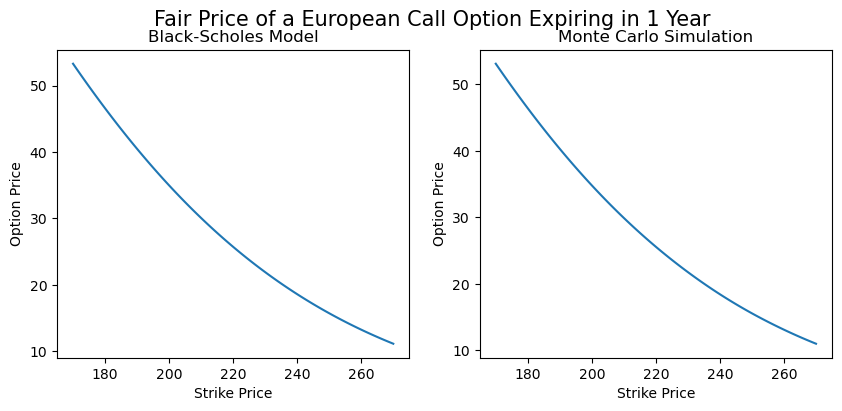

In [13]:
# plot strike price against call option price for both methods
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle("Fair Price of a European Call Option Expiring in 1 Year", fontsize=15)
axes[0].plot(K, euro_call_prices_bsm)
axes[0].set_title("Black-Scholes Model")
axes[1].plot(K, euro_call_prices)
axes[1].set_title("Monte Carlo Simulation")
axes[0].set_xlabel("Strike Price")
axes[1].set_xlabel("Strike Price")
axes[0].set_ylabel("Option Price")
axes[1].set_ylabel("Option Price")

For American options, you can exercise at any time, so the time to maturity is split into steps the option is priced at each one. The price of an American call option at time $t$ is $\max{\left((S_t - K)^+, C_t\right)}$ where $C_t$ is the continuation value at time $t$. To estimate the continuation value, least squares regression is used to estimate the expected cash flow from continuing the option's life conditional on the stock price at time $t$. Let $X$ be the stock prices at time $t$ such that the option is in-the-money, and $Y$ the corresponding cash flows recieved at time $t+1$ if the option is not exercised at time $t$. $Y$ is then regressed on $X$ and $X^2$, leading to the continuation values $E\left[Y|X\right]$. It is then considered optimal to exercise if the exercise price $(S_T - K)^+$ is larger than the continuation value, 

In [51]:
# pricing an American call using Monte Carlo and Longstaff-Schwarz Algorithm
def us_call_price(sigma, S0, K, T, r, Z):
    # number of simulations
    n_sim = Z.shape[0]
    # number of steps (opportunities to exercise)
    n_steps = Z.shape[1]
    # change in time at each step
    dt = T / n_steps
    # store stock prices
    S = np.zeros((n_sim, n_steps + 1))
    # set initial stock price
    S[:, 0] = S0

    # loop over steps
    for t in range(1, n_steps + 1):
        # new stock prices at step t
        S[:, t] = S[:, t-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z[:, t-1])
    # compute payoffs
    payoffs = np.maximum(S[:, -1] - K, 0)
    cashflow = payoffs.copy()
    
    # filter out paths that have already been exercised
    not_exercised = np.ones(len(cashflow), dtype=bool)

    # go through steps backwards
    for t in range(n_steps - 1, 0, -1):
        # discount the cashflow from step t + 1
        cashflow = np.exp(-r * dt) * cashflow
        # find cashflows that are in-the-money
        in_the_money = S[:, t] > K
        # filter out previously exercised paths
        in_the_money = in_the_money & not_exercised
        # X is the stock prices that are in-the-money
        X = S[in_the_money, t]
        # Y is the corresponding discounted cash flows recieved at step t + 1
        Y = cashflow[in_the_money]

        # check if any in-the-money stock prices exist on this path
        if len(X) > 0:
            # creates matrix corresponding to a + bX + cX^2 polynomial
            A = np.vstack([np.ones(len(X)), X, X**2]).T
            # performs least squares regression on A @ coefs = Y
            coefs = np.linalg.lstsq(A, Y, rcond=None)[0]
            # use coefficients to estimate continuation value, compute E(Y|X)
            continuation_value = A @ coefs

            # compute exercise value
            exercise_value = X - K

            # find incides where it is better to exercise than continue
            exercise = exercise_value > continuation_value
            exercise_indices = np.where(in_the_money)[0][exercise]
            # store so that these indices cannot be exercised again
            not_exercised[exercise_indices] = False

            # update cashflows with new payoffs
            cashflow[exercise_indices] = exercise_value[exercise]

    # discount the cashflows back to time 0
    discounted_cashflow = np.exp(-r * dt) * cashflow
    # return option price, payoffs and stock prices
    return (np.mean(discounted_cashflow), discounted_cashflow, S)

# pricing an American put using Monte Carlo and Longstaff-Schwarz Algorithm
def us_put_price(sigma, S0, K, T, r, Z):
    # number of simulations
    n_sim = Z.shape[0]
    # number of steps (opportunities to exercise)
    n_steps = Z.shape[1]
    # change in time at each step
    dt = T / n_steps
    # store stock prices
    S = np.zeros((n_sim, n_steps + 1))
    # set initial stock price
    S[:, 0] = S0

    # loop over steps
    for t in range(1, n_steps + 1):
        # new stock prices at step t
        S[:, t] = S[:, t-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z[:, t-1])
    # compute payoffs
    payoffs = np.maximum(K - S[:, -1], 0)
    cashflow = payoffs.copy()
    
    # filter out paths that have already been exercised
    not_exercised = np.ones(len(cashflow), dtype=bool)

    # go through steps backwards
    for t in range(n_steps - 1, 0, -1):
        # discount the cashflow from step t + 1
        cashflow = np.exp(-r * dt) * cashflow
        # find cashflows that are in-the-money
        in_the_money = S[:, t] < K
        # filter out previously exercised paths
        in_the_money = in_the_money & not_exercised
        # X is the stock prices that are in-the-money
        X = S[in_the_money, t]
        # Y is the corresponding discounted cash flows recieved at step t + 1
        Y = cashflow[in_the_money]

        # check if any in-the-money stock prices exist on this path
        if len(X) > 0:
            # creates matrix corresponding to a + bX + cX^2 polynomial
            A = np.vstack([np.ones(len(X)), X, X**2]).T
            # performs least squares regression on A @ coefs = Y
            coefs = np.linalg.lstsq(A, Y, rcond=None)[0]
            # use coefficients to estimate continuation value, compute E(Y|X)
            continuation_value = A @ coefs

            # compute exercise value
            exercise_value = K - X

            # find incides where it is better to exercise than continue
            exercise = exercise_value > continuation_value
            exercise_indices = np.where(in_the_money)[0][exercise]
            # store so that these indices cannot be exercised again
            not_exercised[exercise_indices] = False

            # update cashflows with new payoffs
            cashflow[exercise_indices] = exercise_value[exercise]

    # discount the cashflows back to time 0
    discounted_cashflow = np.exp(-r * dt) * cashflow
    # return option price, payoffs and stock prices
    return (np.mean(discounted_cashflow), discounted_cashflow, S)

In [52]:
n_sim = 10_000
n_steps = 52
# random samples from normal distribution
Z = np.random.randn(n_sim, n_steps)
us_call_prices = np.zeros(len(K))
us_put_prices = np.zeros(len(K))
# loop over strike prices
for i in tqdm(range(len(K))):
    K0 = K[i]
    us_call_prices[i] = us_call_price(sigma, S0, K0, T, r, Z)[0]
    us_put_prices[i] = us_put_price(sigma, S0, K0, T, r, Z)[0]

  0%|          | 0/101 [00:00<?, ?it/s]

Text(0, 0.5, 'Stock Price')

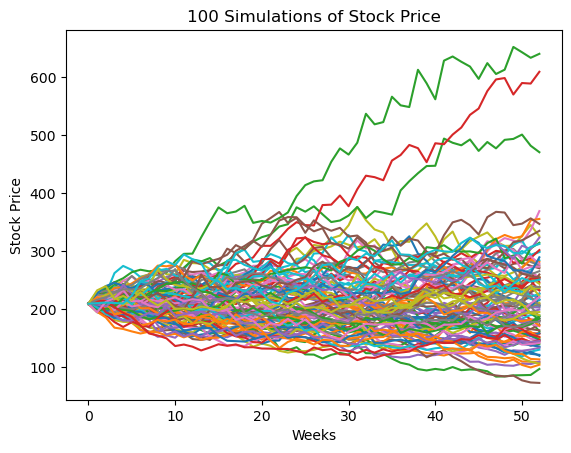

In [53]:
_, _, S = us_call_price(sigma, S0, 220, T, r, Z)
for i in range(100):
    plt.plot(np.arange(0, 53), S[i, :])
plt.title("100 Simulations of Stock Price")
plt.xlabel("Weeks")
plt.ylabel("Stock Price")

In [54]:
# pricing Asian call option
def asian_call_price(sigma, S0, K, T, r, Z):
    # number of simulations
    n_sim = Z.shape[0]
    # number of steps (opportunities to exercise)
    n_steps = Z.shape[1]
    # change in time at each step
    dt = T / n_steps
    # store stock prices
    S = np.zeros((n_sim, n_steps + 1))
    # set initial stock price
    S[:, 0] = S0
    # loop over steps
    for t in range(1, n_steps + 1):
        # new stock prices at step t
        S[:, t] = S[:, t-1] * np.exp((r - (sigma**2) / 2) * dt + sigma * np.sqrt(dt) * Z[:, t-1])
    # compute average of stock price over each path/simulation
    S_avg = np.mean(S, axis=1)
    # compute discounted payoffs for Asian call option
    payoffs = np.exp(-r * T) * np.maximum(S_avg - K, 0)
    # return option price, payoffs and stock prices
    return np.mean(payoffs), payoffs, S

# pricing Asian put option
def asian_put_price(sigma, S0, K, T, r, Z):
    # number of simulations
    n_sim = Z.shape[0]
    # number of steps (opportunities to exercise)
    n_steps = Z.shape[1]
    # change in time at each step
    dt = T / n_steps
    # store stock prices
    S = np.zeros((n_sim, n_steps + 1))
    # set initial stock price
    S[:, 0] = S0
    # loop over steps
    for t in range(1, n_steps + 1):
        # new stock prices at step t
        S[:, t] = S[:, t-1] * np.exp((r - (sigma**2) / 2) * dt + sigma * np.sqrt(dt) * Z[:, t-1])
    # compute average of stock price over each path/simulation
    S_avg = np.mean(S, axis=1)
    # compute discounted payoffs for Asian call option
    payoffs = np.exp(-r * T) * np.maximum(K - S_avg, 0)
    # return option price, payoffs and stock prices
    return np.mean(payoffs), payoffs, S

In [55]:
# pricing Knock In Barrier call option
def barrier_call_price(sigma, S0, K, B, T, r, Z):
    # number of simulations
    n_sim = Z.shape[0]
    # number of steps (opportunities to exercise)
    n_steps = Z.shape[1]
    # change in time at each step
    dt = T / n_steps
    # store stock prices
    S = np.zeros((n_sim, n_steps + 1))
    # set initial stock price
    S[:, 0] = S0
    # loop over steps
    for t in range(1, n_steps + 1):
        # new stock prices at step t
        S[:, t] = S[:, t-1] * np.exp((r - (sigma**2) / 2) * dt + sigma * np.sqrt(dt) * Z[:, t-1])
    # compute discounted payoffs for a standard European call option
    payoffs = np.exp(-r * T) * np.maximum(S[:, -1] - K, 0)
    # set paths to zero if barrier has not been reached
    max_S = np.max(S, axis=1)
    payoffs[max_S < B] = 0
    # return option price, payoffs and stock prices
    return np.mean(payoffs), payoffs, S

# pricing Knock In Barrier put option
def barrier_put_price(sigma, S0, K, B, T, r, Z):
    # number of simulations
    n_sim = Z.shape[0]
    # number of steps (opportunities to exercise)
    n_steps = Z.shape[1]
    # change in time at each step
    dt = T / n_steps
    # store stock prices
    S = np.zeros((n_sim, n_steps + 1))
    # set initial stock price
    S[:, 0] = S0
    # loop over steps
    for t in range(1, n_steps + 1):
        # new stock prices at step t
        S[:, t] = S[:, t-1] * np.exp((r - (sigma**2) / 2) * dt + sigma * np.sqrt(dt) * Z[:, t-1])
    # compute discounted payoffs for a standard European call option
    payoffs = np.exp(-r * T) * np.maximum(K - S[:, -1], 0)
    # set paths to zero if barrier has not been reached
    max_S = np.max(S, axis=1)
    payoffs[max_S < B] = 0
    # return option price, payoffs and stock prices
    return np.mean(payoffs), payoffs, S

In [56]:
n_sim = 10_000
n_steps = 52
# random samples from normal distribution
Z = np.random.randn(n_sim, n_steps)
asian_call_prices = np.zeros(len(K))
# loop over strike prices
for i, K0 in enumerate(K):
    asian_call_prices[i] = asian_call_price(sigma, S0, K0, T, r, Z)[0]

In [57]:
n_sim = 10_000
n_steps = 52
B = 1.5 * S0
# random samples from normal distribution
Z = np.random.randn(n_sim, n_steps)
barrier_call_prices = np.zeros(len(K))
# loop over strike prices
for i, K0 in enumerate(K):
    barrier_call_prices[i] = barrier_call_price(sigma, S0, K0, B, T, r, Z)[0]

Text(0.5, 1.0, 'Option Prices for Varying Strike Price')

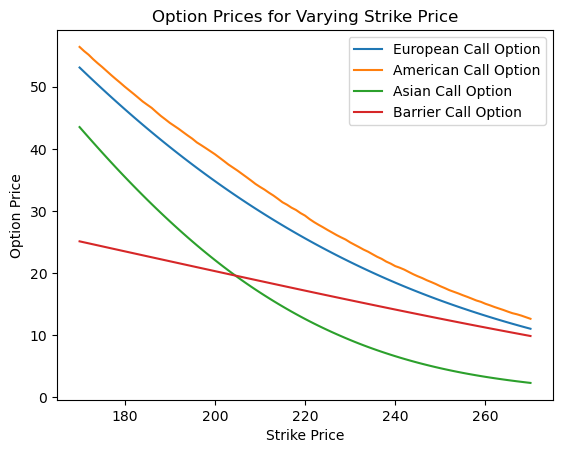

In [58]:
plt.plot(K, euro_call_prices, label="European Call Option")
plt.plot(K, us_call_prices, label="American Call Option")
plt.plot(K, asian_call_prices, label="Asian Call Option")
plt.plot(K, barrier_call_prices, label="Barrier Call Option")
plt.legend()
plt.xlabel("Strike Price")
plt.ylabel("Option Price")
plt.title("Option Prices for Varying Strike Price")

Text(0.5, 1.0, 'Option Prices for Varying Strike Price')

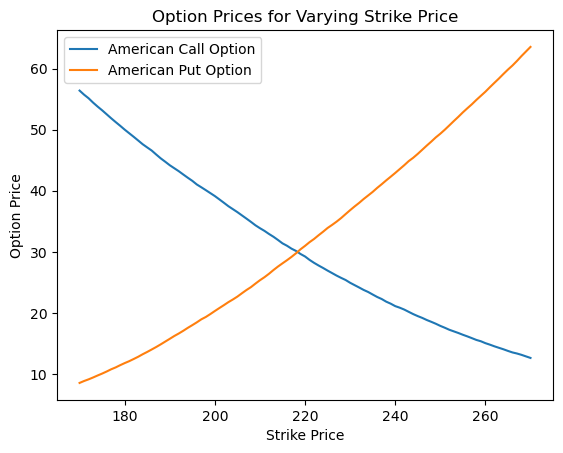

In [59]:
plt.plot(K, us_call_prices, label="American Call Option")
plt.plot(K, us_put_prices, label="American Put Option")
plt.legend()
plt.xlabel("Strike Price")
plt.ylabel("Option Price")
plt.title("Option Prices for Varying Strike Price")

In [23]:
# use one strike price
K0 = 220

In [24]:
# adjust number of simulations
n_sim = 3_000

In [25]:
# pricing a Euro call option without any variance reduction
# random samples from normal distribution
Z = np.random.randn(n_sim)
price_base, payoffs_base = euro_call_price(sigma, S0, K0, T, r, Z)
payoff_variance_base = np.var(payoffs_base)

In [26]:
# pricing a European call option using Antithetic variates
# random samples from normal distribution but half the size
Z_half = np.random.randn(n_sim // 2)
# combine it with the negative of itself
Z = np.concatenate([Z_half, -Z_half])
price_av, payoffs_av = euro_call_price(sigma, S0, K0, T, r, Z)
payoff_variance_av = np.var(payoffs_av)

In [27]:
print(f"Price of Option without Variance Reduction: {price_base}")
print(f"Price of Option with Antithetic Variates: {price_av}\n")
print(f"Variance of Payoffs without Variance Reduction: {payoff_variance_base}")
print(f"Variance of Payoffs with Antithetic Variates: {payoff_variance_av}")
print(f"Variance reduction: {100 * (1 - payoff_variance_av / payoff_variance_base):.2f}%")

Price of Option without Variance Reduction: 25.625736996130698
Price of Option with Antithetic Variates: 25.196324290613216

Variance of Payoffs without Variance Reduction: 2183.803130214769
Variance of Payoffs with Antithetic Variates: 2118.647493045838
Variance reduction: 2.98%


In [28]:
# random samples from normal distribution
Z = np.random.randn(n_sim, n_steps)
price_base, asian_payoffs, _ = asian_call_price(sigma, S0, K0, T, r, Z)
payoff_variance_base = np.var(asian_payoffs)

In [29]:
# pricing an Asian call option using control variates
# European payoffs
_, euro_payoffs = euro_call_price(sigma, S0, K0, T, r, Z[:,0])

# Black-Scholes price for European call for control variate mean
bsm_price = euro_call_price_bsm(sigma, S0, K0, T, r)

# covariances
cov_XY = np.cov(asian_payoffs, euro_payoffs, ddof=1)[0,1]
var_Y = np.var(euro_payoffs)
c = cov_XY / var_Y if var_Y > 0 else 0

# control variate estimator
adjusted_payoffs = asian_payoffs - c * (euro_payoffs - bsm_price)
price_cv = np.mean(adjusted_payoffs)
payoff_variance_cv = np.var(adjusted_payoffs)

In [30]:
print(f"Price of Option without Variance Reduction: {price_base}")
print(f"Price of Option with Control Variates: {price_cv}\n")
print(f"Variance of Payoffs without Variance Reduction: {payoff_variance_base}")
print(f"Variance of Payoffs with Control Variates: {payoff_variance_cv}")
print(f"Variance reduction: {100 * (1 - payoff_variance_cv / payoff_variance_base):.2f}%")

Price of Option without Variance Reduction: 12.825223376889534
Price of Option with Control Variates: 12.831377322049457

Variance of Payoffs without Variance Reduction: 565.9024609532856
Variance of Payoffs with Control Variates: 549.9922163201752
Variance reduction: 2.81%


In [31]:
# barrier call option price with importance sampling
def barrier_call_importance_sampling(sigma, S0, K, B, mu, T, r, Z):
    # number of simulations
    n_sim = Z.shape[0]
    # number of steps (opportunities to exercise)
    n_steps = Z.shape[1]
    # change in time at each step
    dt = T / n_steps
    # store stock prices
    S = np.zeros((n_sim, n_steps + 1))
    # set initial stock price
    S[:, 0] = S0
    # shift Z
    Z_shifted = Z + mu
    # loop over steps
    for t in range(1, n_steps + 1):
        # new stock prices at step t
        S[:, t] = S[:, t-1] * np.exp((r - (sigma**2) / 2) * dt + sigma * np.sqrt(dt) * Z_shifted[:, t-1])
    # compute discounted payoffs for a standard European call option
    payoffs = np.exp(-r * T) * np.maximum(S[:, -1] - K, 0)
    # set paths to zero if barrier has not been reached
    max_S = np.max(S, axis=1)
    payoffs[max_S < B] = 0
    # compute likelihood ratio weights
    sum_Z = np.sum(Z_shifted, axis=1)
    L = np.exp(-mu * sum_Z + 0.5 * n_steps * mu**2)
    # weighted payoffs
    weighted_payoffs = payoffs * L
    # return option price, payoffs and stock prices
    return np.mean(weighted_payoffs), weighted_payoffs, S

In [32]:
mu = 0.3
B = 1.8 * S0
Z = np.random.randn(n_sim, n_steps)
price_base, payoffs_base, _ = barrier_call_price(sigma, S0, K0, B, T, r, Z)
price_is, payoffs_is, _ = barrier_call_importance_sampling(sigma, S0, K0, B, mu, T, r, Z)
payoff_variance_base = np.var(payoffs_base)
payoff_variance_is = np.var(payoffs_is)

In [33]:
print(f"Price of Option without Variance Reduction: {price_base}")
print(f"Price of Option with Importance Sampling: {price_is}\n")
print(f"Variance of Payoffs without Variance Reduction: {payoff_variance_base}")
print(f"Variance of Payoffs with Importance Sampling: {payoff_variance_is}")
print(f"Variance reduction: {100 * (1 - payoff_variance_is / payoff_variance_base):.2f}%")

Price of Option without Variance Reduction: 8.867507737124916
Price of Option with Importance Sampling: 8.481515738821413

Variance of Payoffs without Variance Reduction: 1539.182110158711
Variance of Payoffs with Importance Sampling: 119.74036972574999
Variance reduction: 92.22%


In [34]:
# find best mu
mu_range = np.linspace(0, 1, 100)
Z = np.random.randn(n_sim, n_steps)
best_mu = 0
best_variance = np.inf
for mu in mu_range:
    price_base, payoffs_base, _ = barrier_call_price(sigma, S0, K0, B, T, r, Z)
    price_is, payoffs_is, _ = barrier_call_importance_sampling(sigma, S0, K0, B, mu, T, r, Z)
    payoff_variance_is = np.var(payoffs_is)
    if payoff_variance_is < best_variance and np.abs(price_is - price_base) < 1:
        best_mu = mu
        best_variance = payoff_variance_is
print(f"Best Shift Value: {np.round(best_mu, 2)} with variance {np.round(best_variance, 2)}")

Best Shift Value: 0.26 with variance 112.72


In [35]:
# compute Delta using finite differences
def delta_fd(pricing_func, epsilon, sigma, S0, *args):
    V_plus = pricing_func(sigma, S0 + epsilon, *args)[0]
    V_minus = pricing_func(sigma, S0 - epsilon, *args)[0]
    return (V_plus - V_minus) / (2 * epsilon)

# compute Gamma using finite differences
def gamma_fd(pricing_func, epsilon, sigma, S0, *args):
    V_plus = pricing_func(sigma, S0 + epsilon, *args)[0]
    V = pricing_func(sigma, S0, *args)[0]
    V_minus = pricing_func(sigma, S0 - epsilon, *args)[0]
    return (V_plus - 2 * V + V_minus) / (epsilon**2)

# compute Vega using finite differences
def vega_fd(pricing_func, epsilon, sigma, *args):
    V_plus = pricing_func(sigma + eps, *args)[0]
    V_minus = pricing_func(sigma - eps, *args)[0]
    return (V_plus - V_minus) / (2 * epsilon)

# compute Rho using finite differences
def rho_fd(pricing_func, epsilon, r, Z, *args):
    V_plus = pricing_func(*args, r + eps, Z)[0]
    V_minus = pricing_func(*args, r - eps, Z)[0]
    return (V_plus - V_minus) / (2 * epsilon)

# compute Theta using finite differences
def theta_fd(pricing_func, epsilon, T, r, Z, *args):
    V_minus = pricing_func(*args, T - epsilon, r, Z)[0]
    V = pricing_func(*args, T, r, Z)[0]
    return (V_minus - V) / epsilon

In [36]:
n_sim = 10_000
K0 = 250
eps = 0.1

In [37]:
Z = np.random.randn(n_sim)
delta = delta_fd(euro_call_price, eps, sigma, S0, K0, T, r, Z)
gamma = gamma_fd(euro_call_price, eps, sigma, S0, K0, T, r, Z)
vega = vega_fd(euro_call_price, eps, sigma, S0, K0, T, r, Z)
rho = rho_fd(euro_call_price, eps, r, Z, sigma, S0, K0, T)
theta = theta_fd(euro_call_price, eps, T, r, Z, sigma, S0, K0)
print(f"Delta: {delta}")
print(f"Gamma: {gamma}")
print(f"Vega: {vega}")
print(f"Rho: {rho}")
print(f"Theta: {theta}")

Delta: 0.38922202760239166
Gamma: 0.008640734691134353
Vega: 78.4224043136464
Rho: 66.38959242804968
Theta: -15.599892595598064


In [38]:
S = np.arange(100, 300)
deltas = np.zeros(len(S))
gammas = np.zeros(len(S))
for i, S_value in enumerate(S):
    deltas[i] = delta_fd(euro_call_price, eps, sigma, S_value, K0, T, r, Z)
    gammas[i] = gamma_fd(euro_call_price, eps, sigma, S_value, K0, T, r, Z)

sigmas = np.linspace(0, 1, 100)
vegas = np.zeros(len(sigmas))
for i, sigma_value in enumerate(sigmas):
    vegas[i] = vega_fd(euro_call_price, eps, sigma_value, S0, K0, T, r, Z)
    
rates = np.linspace(0, 1, 100)
rhos = np.zeros(len(rates))
for i, r_value in enumerate(rates):
    rhos[i] = rho_fd(euro_call_price, eps, r_value, Z, sigma, S0, K0, T)
    
times = np.linspace(0.1, 3, 100)
thetas = np.zeros(len(times))
for i, time in enumerate(times):
    thetas[i] = theta_fd(euro_call_price, eps, time, r, Z, sigma, S0, K0)

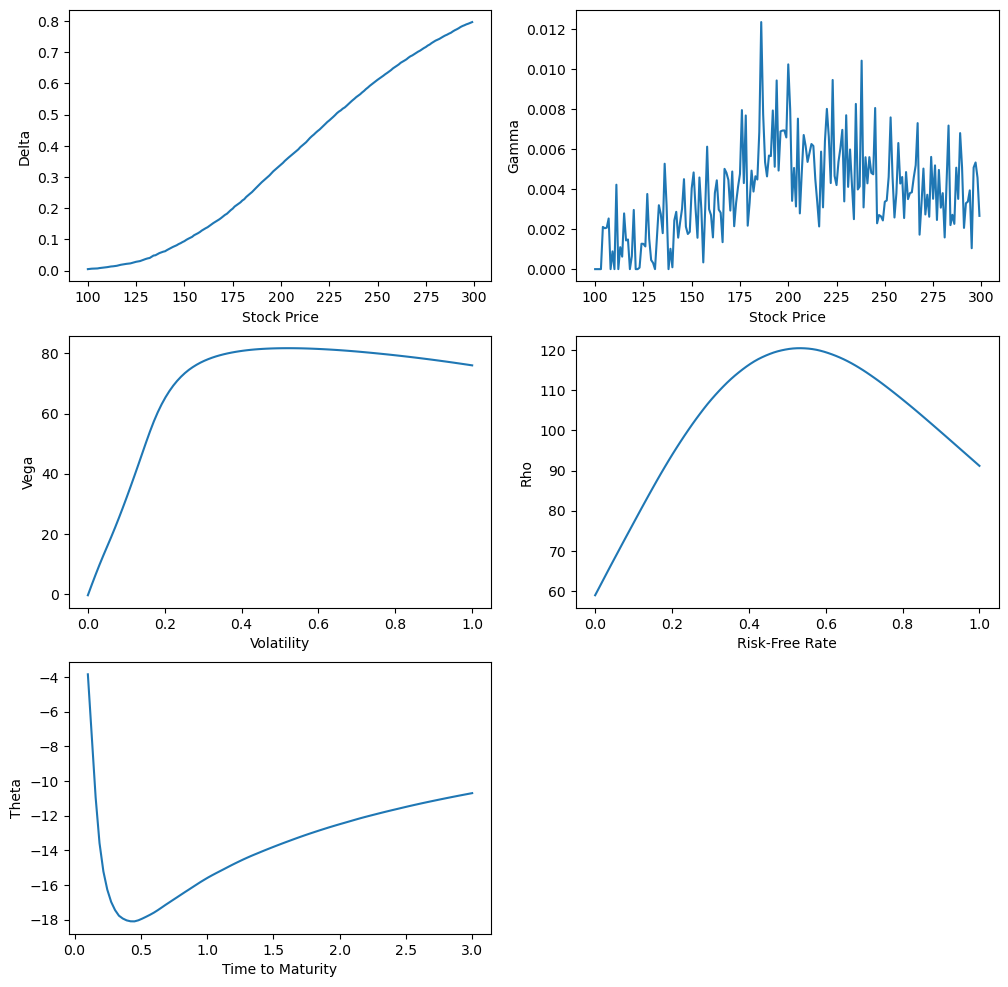

In [39]:
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
axes[0,0].plot(S, deltas)
axes[0,0].set_xlabel("Stock Price")
axes[0,0].set_ylabel("Delta")
axes[0,1].plot(S, gammas)
axes[0,1].set_xlabel("Stock Price")
axes[0,1].set_ylabel("Gamma")
axes[1,0].plot(sigmas, vegas)
axes[1,0].set_xlabel("Volatility")
axes[1,0].set_ylabel("Vega")
axes[1,1].plot(rates, rhos)
axes[1,1].set_xlabel("Risk-Free Rate")
axes[1,1].set_ylabel("Rho")
axes[2,0].plot(times, thetas)
axes[2,0].set_xlabel("Time to Maturity")
axes[2,0].set_ylabel("Theta")
fig.delaxes(axes[2, 1])

In [40]:
n_steps = 252
n_sim = 100_000

In [41]:
# delta hedging a European call option
def delta_hedge_euro_call(sigma, S0, K0, T, r, Z, n_steps, n_sim, fee_rate, eps):
    # store share prices
    S = np.zeros(n_steps + 1)
    # store option prices
    C = np.zeros(n_steps + 1)
    # store delta values
    deltas = np.zeros(n_steps + 1)
    # store P&L balance
    balance = np.zeros(n_steps + 1)
    # initial share price
    S[0] = S0
    # initial option price using Black Scholes 
    C[0] = euro_call_price_bsm(sigma, S0, K0, T, r)
    # intial delta value
    deltas[0] = delta_fd(euro_call_price, eps, sigma, S0, K0, T, r, Z)
    # intial balance from being short the call option and long the replicating shares
    balance[0] = C[0] - deltas[0] * S[0] - deltas[0] * S[0] * fee_rate
    dt = T / n_steps
    # random sample for the path of the stock
    Z = np.random.randn(n_steps)
    # loop over steps
    for t in range(1, n_steps + 1):
        # update share price
        S[t] = S[t - 1] * np.exp((r - (sigma**2) / 2) * dt + sigma * np.sqrt(dt) * Z[t - 1])
        Z_sim = np.random.randn(n_sim)
        # update delta value
        deltas[t] = delta_fd(euro_call_price, eps, sigma, S[t], K0, T - t * dt, r, Z_sim)
        # update balance by adding interest
        balance[t] = balance[t - 1] * np.exp(r * dt)
        if deltas[t] < deltas[t - 1] - eps or deltas[t] > deltas[t - 1] + eps: 
            # percentage fee 
            fee = np.abs(deltas[t] - deltas[t - 1]) * fee_rate * S[t]
            balance[t] -= (deltas[t] - deltas[t - 1]) * S[t] + fee
        else:
            deltas[t] = deltas[t - 1]
    # updating balance to account for money lost from the option being exercised and selling remaining shares
    fee = deltas[-1] * S[-1] * fee_rate
    balance[-1] = balance[-1] + deltas[-1] * S[-1] - np.maximum(S[-1] - K0, 0) - fee
    return deltas, balance

In [42]:
# number of simulations
eps_values = [0.001, 0.05, 0.1, 0.2, 0.5, 1]
N = 1000
n_steps = 100
n_sim = 1000
fee_rate = 0.01
profits_eps = []
for eps in eps_values:
    profits = np.zeros(N)
    for i in tqdm(range(N)):
        Z = np.random.randn(n_steps)
        deltas, balance = delta_hedge_euro_call(sigma, S0, K0, T, r, Z, n_steps, n_sim, fee_rate, eps)
        profits[i] = balance[-1]
    profits_eps.append(profits)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [43]:
for i in range(len(eps_values)):
    print(f"Epsilon = {eps_values[i]}")
    print(f"Mean P&L: {'-' if np.mean(profits_eps[i]) < 0 else ''}£{np.abs(np.round(np.mean(profits_eps[i]), 2))}")
    print(f"Variance of P&Ls: {np.round(np.var(profits_eps[i]), 2)}")
    lower = np.round(np.percentile(profits_eps[i], 2.5), 2)
    upper = np.round(np.percentile(profits_eps[i], 97.5), 2)
    print(f"95% Confidence Interval for P&Ls: ({'-' if lower < 0 else ''}£{np.abs(lower)}, {'-' if upper < 0 else ''}£{np.abs(upper)})\n")

Epsilon = 0.001
Mean P&L: -£9.51
Variance of P&Ls: 28.45
95% Confidence Interval for P&Ls: (-£22.04, -£1.96)

Epsilon = 0.05
Mean P&L: -£7.14
Variance of P&Ls: 26.46
95% Confidence Interval for P&Ls: (-£18.79, £0.25)

Epsilon = 0.1
Mean P&L: -£5.32
Variance of P&Ls: 29.61
95% Confidence Interval for P&Ls: (-£17.41, £3.4)

Epsilon = 0.2
Mean P&L: -£4.25
Variance of P&Ls: 61.03
95% Confidence Interval for P&Ls: (-£21.27, £8.97)

Epsilon = 0.5
Mean P&L: -£3.51
Variance of P&Ls: 287.98
95% Confidence Interval for P&Ls: (-£38.41, £24.85)

Epsilon = 1
Mean P&L: -£2.12
Variance of P&Ls: 507.27
95% Confidence Interval for P&Ls: (-£62.26, £25.64)



In [ ]:
#D. Naive Momentum Strategy
#Simulate a strategy like:
#"Buy if price has risen 3 days in a row, sell otherwise"
#Track P&L over thousands of synthetic paths.
#Introduce mean-reverting vs trending regimes.
#It won’t beat the market, but it shows why stat arb is hard.

#E. Option Portfolio Greeks Management
#Create a portfolio of calls/puts,
#Show how to neutralize delta, gamma, vega via combinations,
#Implement dynamic adjustment over time.
#Shows off understanding of risk exposure at a desk level.

# 5 - Polish and Present, Plot convergence of MC estimates, Comment on computational cost
# Discuss accuracy, variance, confidence intervals